# NDSI for Switzerland with Landsat 5 and 8

In [64]:
# Import dependencies
%matplotlib inline

import os
import sys
import calendar
# import shutil
import gdal
import osr

import numpy as np
import xarray as xr

from datetime import datetime
# from multiprocessing import Pool, Lock, Manager
from matplotlib import colors
from IPython.display import display, Javascript


import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
dc = datacube.Datacube()
api = DataAccessApi(config="/home/localuser/.datacube.conf")

from utils.data_cube_utilities.dc_display_map import display_map, _degree_to_zoom_level
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from swiss_utils.data_cube_utilities.sdc_utilities import printandlog, load_multi_clean


import warnings
warnings.filterwarnings("ignore")

In [95]:
# Configuration section

products = ["ls8_lasrc_swiss","ls7_ledaps_swiss", "ls5_ledaps_swiss"]
platforms = ["LANDSAT_8","LANDSAT_7","LANDSAT_5"]

product = ["ls8_lasrc_swiss"]
platform = ["LANDSAT_8"]

measurements = ['green','swir1','pixel_qa']
bands = ['red', 'green', 'blue', 'nir','swir1','swir2']

# # Switzerland
#min_lon =  5.85
#max_lon =  10.55
#min_lat = 45.75
#max_lat = 47.85

start_date = datetime.strptime("2019-02-13", '%Y-%m-%d')
end_date = datetime.strptime("2019-02-15", '%Y-%m-%d')

start_year = 2019
end_year = 2019

start_month = 2
end_month = 2

##Define months
sel_months = [2]

ind_season = ['DJF','DJF',
              'MAM','MAM','MAM',
              'JJA','JJA','JJA',
              'SON','SON','SON',
              'DJF']

work_path = './bigdata/Test_CP'
log_name = 'test_cp.log'
user_mail = 'cpoussin0@gmail.com'

In [96]:
display_map(latitude = (min_lat, max_lat), longitude = (min_lon, max_lon))

## Case study NDSI threshold pred model

In [121]:
# Import necessary stuff
%matplotlib inline

from datetime import datetime
from itertools import combinations, product
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from time import time

from collections import Counter
from osgeo import gdal #GDAl is Geospatial Data Abstraction Library for manipuling
                        #geospatial raster data
    
import pandas as pd #for data analysing

#to desplay AOI
from utils.data_cube_utilities.dc_display_map import display_map

from functools import reduce 

from dc_notebook_utilities import generate_metadata_report

# IMPORT EASY_EXPORT FUNCTION
from swiss_utils.data_cube_utilities.sdc_utilities import easy_export

import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi

dc = datacube.Datacube()
api = DataAccessApi(config="/home/localuser/.datacube.conf")

In [122]:
# Function to export pngs

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import exposure

def fig_aspects(sizes, max_size = 20):
    pxx = sizes['longitude']
    pxy = sizes['latitude']
    orient = 'horizontal'
    posit = 'bottom'
    width = max_size
    height = pxy * (max_size / pxx)
    if pxx * 1.01 < pxy:
        orient = 'vertical'
        posit = 'right'
        height = max_size
        width = pxx * (max_size / pxy)
    return (height, width, orient, posit)

def xtrms_format(vals):
    min_val = min(vals)
    max_val = max(vals)
    diff_val = max_val - min_val

    digits = 1 if diff_val > 1 else int(round(-np.log10(diff_val),0) + 1)

    return ['{:.{prec}f}'.format(round(min_val, digits), prec = digits),
            '{:.{prec}f}'.format(round(max_val, digits), prec = digits)]

def oneband_fig(data, leg, title, fig_name=None, v_min=None, v_max=None, max_size=16):   
    """
    Description:
      Create a one band (one time) figure
    -----
    Input:
      data: one time xarray.DataArray.
      leg: colormap to be applied (either standard (https://matplotlib.org/examples/color/colormaps_reference.html)
           or custom)
      title: prefix of the figure title
      v_min (OPTIONAL, default minimum value): minimum value to display.
      v_max (OPTIONAL, default maximum value): maximum value to display.
      fig_name (OPTIONAL): file name (including extension) to save the figure (show only if not added to input).
      max_size (OPTIONAL, default 16): maximum size of the figure (either horizontal or vertical).
    Output:
      figure.
    """
    
    height, width, orient, posit = fig_aspects(data.sizes, max_size)

    plt.close('all')
    fig = plt.figure(figsize=(width, height), dpi=150)
    if not v_min and not v_max:
        im = plt.imshow(data, interpolation='nearest', cmap=leg)
    else:
        im = plt.imshow(data, interpolation='nearest', cmap=leg, vmin = v_min, vmax = v_max)
        
    # ticks moved 1 pixel inside to guarantee they are displayed
    plt.yticks([data.shape[0] - 1, 1], xtrms_format(data.latitude.values))
    plt.xticks([1, data.shape[1] - 1], xtrms_format(data.longitude.values))
    
    plt.title(title, weight='bold', fontsize=16)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes(posit, "2%", pad="5%")
    cbar = fig.colorbar(im, orientation=orient, cax=cax)

    plt.tight_layout()
    if fig_name:
        plt.savefig(fig_name)
    else:
        plt.show()
    plt.close()

    return 0

def composite_fig(data, bands, title, fig_name=None, max_size=16, hist_str=None):
    """
    Description:
      Create a three band (one time) composite figure
    -----
    Input:
      data: one time xarray.DataArray containing the three bands mentionned in bands.
      bands: bands to be used in the composite (RGB order).
      title: prefix of the figure title.
      fig_name (OPTIONAL): file name (including extension) to save the figure (show only if not added to input).      
      max_size (OPTIONAL, default 16): maximum size of the figure (either horizontal or vertical).
      hist_str: (OPTIONAL): histogram stretch type (['contr','eq','ad_eq'])
    Output:
      figure.
    """

    # Create a copy to unlink from original dataset
    rgb = data.copy(deep = True)

    height, width, orient, posit = fig_aspects(rgb.sizes, max_size)

    rgb = np.stack([rgb[bands[0]],
                    rgb[bands[1]],
                    rgb[bands[2]]])
    
    for b in range(3):
        # https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
        # Contrast stretching
        if hist_str == 'contr':
            p2, p98 = np.nanpercentile(rgb[b], (2, 98))
            rgb[b] = exposure.rescale_intensity(rgb[b], in_range=(p2, p98))
        # Equalization
        if hist_str == 'eq':
            rgb[b] = exposure.equalize_hist(rgb[b])
        # Adaptive Equalization
        if hist_str == 'ad_eq':
            rgb[b] = exposure.equalize_adapthist(rgb[b], clip_limit=0.03)
    
    rgb = np.stack(rgb, axis = -1)
    
    # normalize between 0 and 1
    rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))
    
    plt.close('all')
    fig = plt.figure(figsize=(width, height), dpi=150)
    im = plt.imshow(rgb, vmin = 0, vmax = 1)

    # ticks moved 1 pixel inside to guarantee they are displayed
    plt.yticks([rgb.shape[0] - 1, 1], xtrms_format(data.latitude.values))
    plt.xticks([1, rgb.shape[1] - 1], xtrms_format(data.longitude.values))

    plt.title(title, weight='bold', fontsize=16)

    plt.tight_layout()
    if fig_name:
        plt.savefig(fig_name)
    else:
        plt.show()
    plt.close()

    return 0

In [123]:
# Configuration section
product = "ls8_lasrc_swiss"
platform = "LANDSAT_8"

bands = ['red', 'green', 'blue', 'nir','swir1','swir2']

##region valais avec le grand Muveran
min_lon =  7.02002
max_lon =  7.270033
min_lat = 46.099872
max_lat = 46.270172



start_date = datetime.strptime("2019-02-13", '%Y-%m-%d')
end_date = datetime.strptime("2019-02-15", '%Y-%m-%d')

##Define months
sel_months = [2]


In [102]:
time_start = datetime.now()
    
# Get a Mini Data Cube
S2 = dc.load(platform=platform,
                     product=product,
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     time=(start_date, end_date),
                     measurements=bands)
dc_time = (datetime.now()-time_start)

# Keep selected months
dataset_s2 = S2.sel(time=np.isin(S2['time.month'], sel_months))
print('Done in %s' % dc_time)

Done in 0:00:00.527280


In [103]:
nodata = -9999
dataset = dataset_s2.where(dataset_s2 != nodata)
dataset_S2 = dataset.dropna('time', how='all')
ts_s2 = dataset_S2.astype('int16')


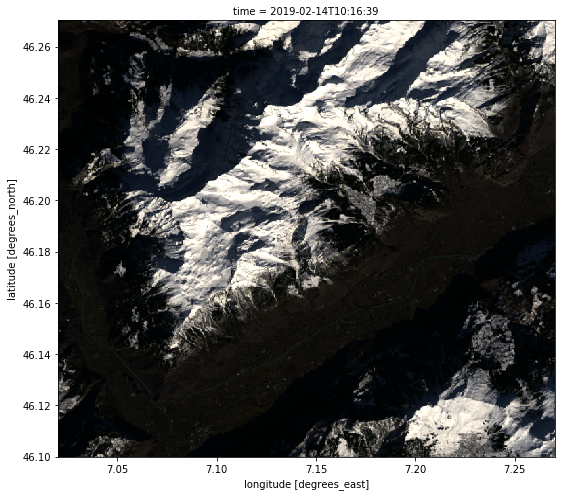

In [104]:
#false colore composite FCC

def Time_list():
    time_list = []
    for i in range(len(ts_s2.time)):
        time_list.append(i)
    return time_list

ncol = 2
ts_s2[['red','green','blue']].isel(time =Time_list()).to_array().plot.imshow(col='time',col_wrap=ncol,size = 7, robust=True)

In [105]:
CS = ts_s2.isel(time=0)

In [76]:
from swiss_utils.data_cube_utilities.sdc_utilities import write_geotiff_from_xr
write_geotiff_from_xr('CS_composite.tif', CS, list(CS.data_vars), compr='')

In [ ]:
CS

In [106]:
#calculate NDVI
def NDSI(dataset_clean):
    return (dataset_clean.nir - dataset_clean.red)/(dataset_clean.nir + dataset_clean.red)

In [107]:
NDSI_CS = (CS.green - CS.swir1)/(CS.green + CS.swir1)

In [108]:
NDSI_CS

<xarray.DataArray (latitude: 500, longitude: 734)>
array([[-0.562968, -0.562968, -0.630495, ...,  0.794011,  0.797543,  0.803746],
       [-0.581301, -0.598781, -0.615487, ...,  0.826478,  0.809859,  0.809939],
       [-0.512139, -0.564374, -0.59899 , ...,  0.855288,  0.843507,  0.811695],
       ...,
       [-0.064516,  0.189189, -0.132075, ...,  0.880805,  0.880805,  0.951104],
       [10.      , -0.931034, -1.444444, ...,  0.873489,  0.873489,  0.877737],
       [ 5.333333, -2.111111,  2.625   , ...,  0.871186,  0.871186,  0.859755]])
Coordinates:
    time       datetime64[ns] 2019-02-14T10:16:39
  * longitude  (longitude) float64 7.02 7.021 7.021 7.021 7.022 7.022 7.022 ...
  * latitude   (latitude) float64 46.27 46.27 46.27 46.27 46.27 46.27 46.27 ...

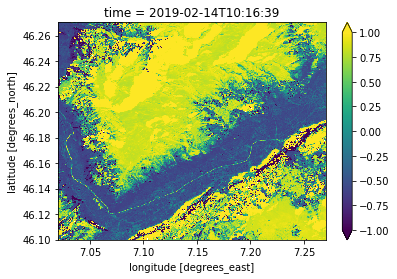

In [109]:
NDSI_CS.plot.imshow(vmin=-1,vmax=1)

In [110]:
NDSI_CS = NDSI_CS.to_dataset(name='NDSI')

In [111]:
type(NDSI_CS)

xarray.core.dataset.Dataset

In [112]:
NDSI_CS

<xarray.Dataset>
Dimensions:    (latitude: 500, longitude: 734)
Coordinates:
    time       datetime64[ns] 2019-02-14T10:16:39
  * longitude  (longitude) float64 7.02 7.021 7.021 7.021 7.022 7.022 7.022 ...
  * latitude   (latitude) float64 46.27 46.27 46.27 46.27 46.27 46.27 46.27 ...
Data variables:
    NDSI       (latitude, longitude) float64 -0.563 -0.563 -0.6305 -0.6725 ...

In [113]:
## Pour enlever les valeurs qui sont plus grande que 1 ##
NDSI = np.where(NDSI_CS.NDSI>1,np.nan,NDSI_CS.NDSI)
NDSI = np.where(NDSI<-1,np.nan,NDSI)

In [114]:
NDSI

array([[-0.56296801, -0.56296801, -0.63049451, ...,  0.79401114,
         0.79754329,  0.8037462 ],
       [-0.58130081, -0.59878111, -0.61548732, ...,  0.82647815,
         0.80985866,  0.80993897],
       [-0.51213873, -0.5643739 , -0.5989899 , ...,  0.85528757,
         0.84350742,  0.81169543],
       ...,
       [-0.06451613,  0.18918919, -0.13207547, ...,  0.88080457,
         0.88080457,  0.9511041 ],
       [        nan, -0.93103448,         nan, ...,  0.87348865,
         0.87348865,  0.87773661],
       [        nan,         nan,         nan, ...,  0.87118644,
         0.87118644,  0.85975533]])

In [115]:
lat = CS['latitude'].values
long = CS['longitude'].values


In [116]:
me = xr.DataArray(NDSI, coords={'latitude': lat, 'longitude': long},
             dims=['latitude', 'longitude'])

In [117]:
CS['NDSI']=me

In [118]:
CS

<xarray.Dataset>
Dimensions:    (latitude: 500, longitude: 734)
Coordinates:
    time       datetime64[ns] 2019-02-14T10:16:39
  * longitude  (longitude) float64 7.02 7.021 7.021 7.021 7.022 7.022 7.022 ...
  * latitude   (latitude) float64 46.27 46.27 46.27 46.27 46.27 46.27 46.27 ...
Data variables:
    red        (latitude, longitude) int16 327 327 255 198 139 12 36 323 542 ...
    green      (latitude, longitude) int16 321 321 269 223 175 102 88 292 ...
    blue       (latitude, longitude) int16 319 319 249 186 160 126 72 189 ...
    nir        (latitude, longitude) int16 983 983 969 896 711 235 420 1086 ...
    swir1      (latitude, longitude) int16 1148 1148 1187 1139 750 370 423 ...
    swir2      (latitude, longitude) int16 752 752 780 753 510 243 335 690 ...
    NDSI       (latitude, longitude) float64 -0.563 -0.563 -0.6305 -0.6725 ...
Attributes:
    crs:      EPSG:4326

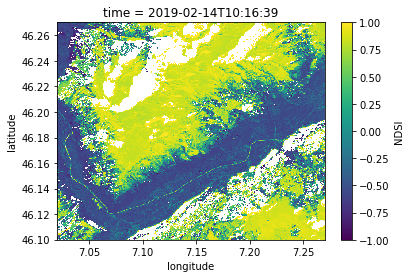

In [119]:
CS.NDSI.plot.imshow(vmin=-1,vmax=1)

In [120]:
from swiss_utils.data_cube_utilities.sdc_utilities import write_geotiff_from_xr
easy_export(CS.NDSI,'NDSI','tif')

'xarray exported succesfully'

## NDWI time period mean 

In [124]:
# Configuration section

products = ["ls8_lasrc_swiss"]
platforms = ["LANDSAT_8"]

measurements=['green', 'swir1','pixel_qa']

# # Switzerland
min_lon =  5.85
max_lon =  10.55
min_lat = 45.75
max_lat = 47.85

# #Basel
#min_lon =  7.31
#max_lon =  7.57
#min_lat = 46.28
#max_lat = 46.33

start_date = datetime.strptime("2019-02-13", '%Y-%m-%d')
end_date = datetime.strptime("2019-02-15", '%Y-%m-%d')

start_year = 2019
end_year = 2019

start_month = 2
end_month = 2

##Define months
sel_months = [2]

ind_season = ['DJF','DJF',
              'MAM','MAM','MAM',
              'JJA','JJA','JJA',
              'SON','SON','SON',
              'DJF']

work_path = './bigdata/Test_CP'
log_name = 'test_cp.log'
user_mail = 'cpoussin0@gmail.com'

In [125]:
def multi_ndsi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndsi = (dataset_clean.green - dataset_clean.swir1) / (dataset_clean.green + dataset_clean.swir1)

        ndsi_count = ndsi.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndsi_max = ndsi.min(dim = ['time'])
        ndsi_max.name = 'ndsi_max'

        # Append result
        ndsi_max_chunks.append(ndsi_max.to_dataset('max'))
        del ndsi_max
        ndsi_count_chunks.append(ndsi_count.to_dataset('count'))
        del ndsi_count
        ndsi_qual_chunks.append(ndsi_qual.to_dataset('qual'))
        del ndsi_qual
        
    else:
        print("N/A")

In [ ]:
# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

print('NDWI mean calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')
    
    ndsi_max_chunks = []
    ndsi_count_chunks = []
    ndsi_qual_chunks = []
    
    bar_len = 20

    for i in range(tot): 
        multi_ndsi(i) 
        filled_len = round(bar_len * (i + 1) /  tot)
        #/r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
        sys.stdout.write('\r[{0}{1}] in {2}'
                             .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
    sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))

    if len(ndsi_max_chunks) > 0:
        # Combine chunks
        with np.errstate(divide='ignore'):
            NDSI = combine_geographic_chunks(ndsi_max_chunks)    
            #NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
            NDSI = NDSI.merge(combine_geographic_chunks(ndsi_qual_chunks))
        del ndsi_max_chunks
        del ndsi_count_chunks
        del ndsi_qual_chunks
        NDSI.to_netcdf('%s/NDSI_%s_%02d.nc' % (work_path, year, month))

printandlog('NDSI monthly mean calculated', log_name, started = start_time)

printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDSI_annual_mean_Landsat completed' %s < %s" % (user_mail, log_name))

NDWI mean calculation started
Processing 2/2019
[#############-------] in 0:03:34.772301

## NDWI : Annual mean

In [ ]:
def multi_ndsi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndsi = (dataset_clean.green - dataset_clean.swir1) / (dataset_clean.green + dataset_clean.swir1)

        ndsi_count = ndsi.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndsi_max = ndsi.max(dim = ['time'])
        ndsi_max.name = 'ndsi_max'

        # Append result
        ndsi_mean_chunks.append(ndsi_max.to_dataset('max'))
        del ndsi_mean
        ndsi_count_chunks.append(ndsi_count.to_dataset('count'))
        del ndsi_count
        ndsi_qual_chunks.append(ndsi_qual.to_dataset('qual'))
        del ndsi_qual
        
    else:
        print("N/A")

In [ ]:
%%time

# Create working directory if necessary
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI annual mean calculation started', log_name, reset = True)
start_time = datetime.now()
years = range(start_year, end_year + 1)

for year_ind, year in enumerate(years):
    starty_time = datetime.now()
    printandlog('Processing year %i' % year, log_name)

    start_date = datetime.strptime("%i-%i-1" % (year, start_month), '%Y-%m-%d')
    # Need to find last days of a given month
    end_date = datetime.strptime("%i-%i-%i" % (year, end_month, calendar.monthrange(year, end_month)[1]), '%Y-%m-%d')
    
    ndwi_mean_chunks = []
    ndwi_count_chunks = []
    ndwi_qual_chunks = []
    
    bar_len = 20

    for i in range(tot): 
        multi_ndwi(i) 
        filled_len = round(bar_len * (i + 1) /  tot)
        #/r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
        sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
    sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))

    if len(ndwi_mean_chunks) > 0:
        # Combine chunks
        with np.errstate(divide='ignore'):
            NDWI = combine_geographic_chunks(ndwi_mean_chunks)    
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
        del ndwi_mean_chunks
        del ndwi_count_chunks
        del ndwi_qual_chunks
        NDWI.to_netcdf('%s/NDWI_%s.nc' % (work_path, year))

printandlog('NDWI annual mean calculated', log_name, started = start_time)

printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_annual_mean_Landsat completed' %s < %s" % (user_mail, log_name))

## NDWI : monthly mean

In [ ]:
def multi_ndwi(i):
        dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
        if dataset_clean != 0:
            ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

            ndwi_count = ndwi.count(dim=['time'])
            ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
            del dataset_clean
            del clean_mask
            ndwi_mean = ndwi.mean(dim=['time'])
            ndwi_mean.name = 'ndwi_mean'

            # Append result
            ndwi_mean_chunks.append(ndwi_mean.to_dataset('mean'))
            del ndwi_mean
            ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
            del ndwi_count
            ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
            del ndwi_qual
            
        else:
            print("N/A")

In [ ]:
# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

print('NDWI mean calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        ndwi_mean_chunks = []
        ndwi_count_chunks = []
        ndwi_qual_chunks = []

        bar_len = 20
        
#         for i, _ in enumerate(p.imap(multi_ndvi, range(tot))):
#             filled_len = round(bar_len * (i + 1) / tot)
#             sys.stdout.write('\r[{0}{1}] in {2}'
#                              .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
#         sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
#         p.close()
        
        for i in range(tot): 
            multi_ndwi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
            sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndwi_mean_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDWI = combine_geographic_chunks(ndwi_mean_chunks)    
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
            del ndwi_mean_chunks
            del ndwi_count_chunks
            del ndwi_qual_chunks
            NDWI.to_netcdf('%s/NDWI_%s_%02d.nc' % (work_path, year, month))

            
printandlog('NDWI monthly mean calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_monthly_mean_Landsat completed' %s < %s" % (user_mail, log_name))

## NDWI : seasonal mean

In [ ]:
# Check ind_season variable and inform in case of problem
if len(ind_season) != 12:
    display(Javascript("""
    require(
        ["base/js/dialog"], 
        function(dialog) {
            dialog.modal({
                title: 'Script interrupted',
                body: 'ind_season variable should contain 12 entries (one per month)',
                buttons: {
                    'Close': {}
                }
            });
        }
    );
    """))
    sys.exit('ind_season variable should contain 12 entries (one per month)')

In [ ]:
# Detect index of starting season year
start_season = ind_season[0]
for m in range(len(ind_season), 0, -1):
    if ind_season[m - 1] != start_season:
        switch_ind = m
        break

In [ ]:
def multi_ndwi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

        ndwi_count = ndwi.count(dim=['time'])
        ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndwi_mean = ndwi.mean(dim=['time'])
        ndwi_mean.name = 'ndwi_mean'
        
        ndwi_std = np.nanstd(ndwi.values, axis=0)
        ndwi_std = xr.DataArray(ndwi_std, dims=['latitude', 'longitude']).astype(np.float64)
        ndwi_std = ndwi_std.assign_coords(latitude=ndwi.latitude, longitude=ndwi.longitude)
        ndwi_std.name = 'ndwi_std'

        # Append result
        ndwi_mean_chunks.append(ndwi_mean.to_dataset('mean'))
        del ndwi_mean
        ndwi_std_chunks.append(ndwi_std.to_dataset('std'))
        del ndwi_std
        ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
        del ndwi_count
        ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
        del ndwi_qual
            
    else:
        print("N/A")

In [ ]:
# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI statistics calculation started', log_name, reset = True)
start_time = datetime.now()

years = range(start_year, end_year + 1)
# List seasons keeping original order
seen = set()
seasons = [x for x in ind_season if not (x in seen or seen.add(x))]

for year in years:
    for season in seasons:
        starty_time = datetime.now()
        printandlog('Processing %s_%s' % (year, season), log_name)
        indxs = [i for i, x in enumerate(ind_season) if x == season]
        if max(indxs) < switch_ind:
            start_date = datetime.strptime("%i-%i-1" % (year, min(indxs) + 1), '%Y-%m-%d')
            end_date = datetime.strptime("%i-%i-%i" % (year, max(indxs) + 1, calendar.monthrange(year, max(indxs) + 1)[1]), '%Y-%m-%d')
        else:
            start_date = datetime.strptime("%i-%i-1" % (year - 1, min(indxs[indxs.index(switch_ind):]) + 1), '%Y-%m-%d')
            end_date = datetime.strptime("%i-%i-%i" % (year, max(indxs[:indxs.index(switch_ind)]) + 1, calendar.monthrange(year, max(indxs[:indxs.index(switch_ind)]) + 1)[1]), '%Y-%m-%d')
        
        ndwi_mean_chunks = []
        ndwi_std_chunks = []
        ndwi_count_chunks = []
        ndwi_qual_chunks = []

        bar_len = 20
#         for i, _ in enumerate(p.imap(multi_ndvi, range(tot))):
#             filled_len = round(bar_len * (i + 1) / tot)
#             sys.stdout.write('\r[{0}{1}] in {2}'
#                              .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
#         sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
#         p.close()
        
        for i in range(tot): 
            multi_ndwi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
            sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndwi_mean_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDWI = combine_geographic_chunks(ndwi_mean_chunks)    
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_std_chunks))
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
            del ndwi_mean_chunks
            del ndwi_count_chunks
            del ndwi_qual_chunks
            NDWI.to_netcdf('%s/NDWI_%s_%s_stats.nc' % (work_path, year, season))

            
printandlog('NDWI seasonal mean calculated', log_name, started = start_time)         
            
printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_seasonal_mean_Landsat completed' %s < %s" % (user_mail, log_name))

## NDWI : Annual median

In [ ]:
def multi_ndwi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

        ndwi_count = ndwi.count(dim=['time'])
        ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndwi_median = ndwi.median(dim = ['time'])
        ndwi_median.name = 'ndwi_median'

        # Append result
        ndwi_median_chunks.append(ndwi_median.to_dataset('median'))
        del ndwi_median
        ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
        del ndwi_count
        ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
        del ndwi_qual
        
    else:
        print("N/A")

In [ ]:
%%time

# Create working directory if necessary
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI annual median calculation started', log_name, reset = True)
start_time = datetime.now()
years = range(start_year, end_year + 1)

for year_ind, year in enumerate(years):
    starty_time = datetime.now()
    printandlog('Processing year %i' % year, log_name)

    start_date = datetime.strptime("%i-%i-1" % (year, start_month), '%Y-%m-%d')
    # Need to find last days of a given month
    end_date = datetime.strptime("%i-%i-%i" % (year, end_month, calendar.monthrange(year, end_month)[1]), '%Y-%m-%d')
    
    ndwi_median_chunks = []
    ndwi_count_chunks = []
    ndwi_qual_chunks = []
    
    bar_len = 20

    for i in range(tot): 
        multi_ndwi(i) 
        filled_len = round(bar_len * (i + 1) /  tot)
        #/r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
        sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
    sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))

    if len(ndwi_median_chunks) > 0:
        # Combine chunks
        with np.errstate(divide='ignore'):
            NDWI = combine_geographic_chunks(ndwi_median_chunks)    
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
        del ndwi_median_chunks
        del ndwi_count_chunks
        del ndwi_qual_chunks
        NDWI.to_netcdf('%s/NDWI_median_%s.nc' % (work_path, year))

printandlog('NDWI annual median calculated', log_name, started = start_time)

printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_annual_median_Landsat completed' %s < %s" % (user_mail, log_name))

## NDWI : Annual Standard deviation

In [ ]:
def multi_ndwi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

        ndwi_count = ndwi.count(dim=['time'])
        ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndwi_std = ndwi.std(dim = ['time'])
        ndwi_std.name = 'ndwi_std'

        # Append result
        ndwi_std_chunks.append(ndwi_std.to_dataset('std'))
        del ndwi_std
        ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
        del ndwi_count
        ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
        del ndwi_qual
        
    else:
        print("N/A")

In [ ]:
%%time

# Create working directory if necessary
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI annual std calculation started', log_name, reset = True)
start_time = datetime.now()
years = range(start_year, end_year + 1)

for year_ind, year in enumerate(years):
    starty_time = datetime.now()
    printandlog('Processing year %i' % year, log_name)

    start_date = datetime.strptime("%i-%i-1" % (year, start_month), '%Y-%m-%d')
    # Need to find last days of a given month
    end_date = datetime.strptime("%i-%i-%i" % (year, end_month, calendar.monthrange(year, end_month)[1]), '%Y-%m-%d')
    
    ndwi_std_chunks = []
    ndwi_count_chunks = []
    ndwi_qual_chunks = []
    
    bar_len = 20

    for i in range(tot): 
        multi_ndwi(i) 
        filled_len = round(bar_len * (i + 1) /  tot)
        #/r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
        sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
    sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))

    if len(ndwi_std_chunks) > 0:
        # Combine chunks
        with np.errstate(divide='ignore'):
            NDWI = combine_geographic_chunks(ndwi_std_chunks)    
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
        del ndwi_std_chunks
        del ndwi_count_chunks
        del ndwi_qual_chunks
        NDWI.to_netcdf('%s/NDWI_std_%s.nc' % (work_path, year))

printandlog('NDWI annual std calculated', log_name, started = start_time)

printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_annual_std_Landsat completed' %s < %s" % (user_mail, log_name))

# NDWI for Switzerland with Sentinel 2

In [ ]:
# Configuration section

products = ["s2_l2a_10m_swiss"]

measurements=['nir', 'swir1','slc']

# # Switzerland
# min_lon =  5.85
# max_lon =  10.55
# min_lat = 45.75
# max_lat = 47.70

#Basel
min_lon =  7.5
max_lon =  7.7
min_lat = 47.5
max_lat = 47.7

start_year = 2015
end_year = 2019

start_month = 1
end_month = 12

ind_season = ['DJF','DJF',
              'MAM','MAM','MAM',
              'JJA','JJA','JJA',
              'SON','SON','SON',
              'DJF']

work_path = './bigdata/JI_NDVI_mean_Stl'
log_name = 'JI_NDVI_mean_Sentinel.log'
user_mail = 'julie.italiano@gmail.com'

## NDWI : annual mean

In [ ]:
def multi_ndwi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

        ndwi_count = ndwi.count(dim=['time'])
        ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndwi_mean = ndwi.mean(dim = ['time'])
        ndwi_mean.name = 'ndwi_mean'

        # Append result
        ndwi_mean_chunks.append(ndwi_mean.to_dataset('mean'))
        del ndwi_mean
        ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
        del ndwi_count
        ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
        del ndwi_qual
        
    else:
        print("N/A")

In [ ]:
%%time

# Create working directory if necessary
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI annual mean calculation started', log_name, reset = True)
start_time = datetime.now()
years = range(start_year, end_year + 1)

for year_ind, year in enumerate(years):
    starty_time = datetime.now()
    printandlog('Processing year %i' % year, log_name)

    start_date = datetime.strptime("%i-%i-1" % (year, start_month), '%Y-%m-%d')
    # Need to find last days of a given month
    end_date = datetime.strptime("%i-%i-%i" % (year, end_month, calendar.monthrange(year, end_month)[1]), '%Y-%m-%d')
    
    ndwi_mean_chunks = []
    ndwi_count_chunks = []
    ndwi_qual_chunks = []
    
    bar_len = 20

    for i in range(tot): 
        multi_ndwi(i) 
        filled_len = round(bar_len * (i + 1) /  tot)
        #/r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
        sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
    sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))

    if len(ndwi_mean_chunks) > 0:
        # Combine chunks
        with np.errstate(divide='ignore'):
            NDWI = combine_geographic_chunks(ndwi_mean_chunks)    
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
            NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
        del ndwi_mean_chunks
        del ndwi_count_chunks
        del ndwi_qual_chunks
        NDWI.to_netcdf('%s/NDWI_%s.nc' % (work_path, year))

printandlog('NDWI annual mean calculated', log_name, started = start_time)

printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_annual_mean_Sentinel completed' %s < %s" % (user_mail, log_name))

## NDWI : monthly mean

In [ ]:
def multi_ndwi(i):
        dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
        if dataset_clean != 0:
            ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

            ndwi_count = ndwi.count(dim=['time'])
            ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
            del dataset_clean
            del clean_mask
            ndwi_mean = ndwi.mean(dim=['time'])
            ndwi_mean.name = 'ndwi_mean'

            # Append result
            ndwi_mean_chunks.append(ndwi_mean.to_dataset('mean'))
            del ndwi_mean
            ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
            del ndwi_count
            ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
            del ndwi_qual
            
        else:
            print("N/A")

In [ ]:
# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

print('NDWI mean calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        ndwi_mean_chunks = []
        ndwi_count_chunks = []
        ndwi_qual_chunks = []

        bar_len = 20
        
#         for i, _ in enumerate(p.imap(multi_ndvi, range(tot))):
#             filled_len = round(bar_len * (i + 1) / tot)
#             sys.stdout.write('\r[{0}{1}] in {2}'
#                              .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
#         sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
#         p.close()
        
        for i in range(tot): 
            multi_ndwi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
            sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndwi_mean_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDWI = combine_geographic_chunks(ndwi_mean_chunks)    
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
            del ndwi_mean_chunks
            del ndwi_count_chunks
            del ndwi_qual_chunks
            NDWI.to_netcdf('%s/NDWI_%s_%02d.nc' % (work_path, year, month))

            
printandlog('NDWI monthly mean calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_monthly_mean_Sentinel completed' %s < %s" % (user_mail, log_name))

## NDWI : seasonal mean

In [ ]:
# Check ind_season variable and inform in case of problem
if len(ind_season) != 12:
    display(Javascript("""
    require(
        ["base/js/dialog"], 
        function(dialog) {
            dialog.modal({
                title: 'Script interrupted',
                body: 'ind_season variable should contain 12 entries (one per month)',
                buttons: {
                    'Close': {}
                }
            });
        }
    );
    """))
    sys.exit('ind_season variable should contain 12 entries (one per month)')

In [ ]:
# Detect index of starting season year
start_season = ind_season[0]
for m in range(len(ind_season), 0, -1):
    if ind_season[m - 1] != start_season:
        switch_ind = m
        break

In [ ]:
def multi_ndwi(i):
        dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndwi = (dataset_clean.nir - dataset_clean.swir1) / (dataset_clean.nir + dataset_clean.swir1)

        ndwi_count = ndwi.count(dim=['time'])
        ndwi_qual = np.rint((ndwi_count / len(ndwi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndwi_mean = ndwi.mean(dim=['time'])
        ndwi_mean.name = 'ndwi_mean'
        
#       ndwi_std = np.nanstd(ndwi.values, axis=0)
#       ndwi_std = xr.DataArray(ndwi_std, dims=['latitude', 'longitude']).astype(np.float64)
#       ndwi_std = nwvi_std.assign_coords(latitude=ndwi.latitude, longitude=ndwi.longitude)
#       ndwi_std.name = 'ndwi_std'

        # Append result
        ndwi_mean_chunks.append(ndwi_mean.to_dataset('mean'))
        del ndwi_mean
#       ndwi_std_chunks.append(ndwi_std.to_dataset('std'))
#       del ndwi_std
        ndwi_count_chunks.append(ndwi_count.to_dataset('count'))
        del ndwi_count
        ndwi_qual_chunks.append(ndwi_qual.to_dataset('qual'))
        del ndwi_qual
            
    else:
        print("N/A")

In [ ]:
# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI statistics calculation started', log_name, reset = True)
start_time = datetime.now()

years = range(start_year, end_year + 1)
# List seasons keeping original order
seen = set()
seasons = [x for x in ind_season if not (x in seen or seen.add(x))]

for year in years:
    for season in seasons:
        starty_time = datetime.now()
        printandlog('Processing %s_%s' % (year, season), log_name)
        indxs = [i for i, x in enumerate(ind_season) if x == season]
        if max(indxs) < switch_ind:
            start_date = datetime.strptime("%i-%i-1" % (year, min(indxs) + 1), '%Y-%m-%d')
            end_date = datetime.strptime("%i-%i-%i" % (year, max(indxs) + 1, calendar.monthrange(year, max(indxs) + 1)[1]), '%Y-%m-%d')
        else:
            start_date = datetime.strptime("%i-%i-1" % (year - 1, min(indxs[indxs.index(switch_ind):]) + 1), '%Y-%m-%d')
            end_date = datetime.strptime("%i-%i-%i" % (year, max(indxs[:indxs.index(switch_ind)]) + 1, calendar.monthrange(year, max(indxs[:indxs.index(switch_ind)]) + 1)[1]), '%Y-%m-%d')
        
        ndwi_mean_chunks = []
#       ndwi_std_chunks = []
        ndwi_count_chunks = []
        ndwi_qual_chunks = []

        bar_len = 20
#         for i, _ in enumerate(p.imap(multi_ndvi, range(tot))):
#             filled_len = round(bar_len * (i + 1) / tot)
#             sys.stdout.write('\r[{0}{1}] in {2}'
#                              .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
#         sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
#         p.close()
        
        for i in range(tot): 
            multi_ndwi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
            sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndwi_mean_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDWI = combine_geographic_chunks(ndwi_mean_chunks)    
#               NDWI = NDWI.merge(combine_geographic_chunks(ndwi_std_chunks))
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_count_chunks))
                NDWI = NDWI.merge(combine_geographic_chunks(ndwi_qual_chunks))
            del ndwi_mean_chunks
            del ndwi_count_chunks
            del ndwi_qual_chunks
            NDWI.to_netcdf('%s/NDWI_%s_%s_stats.nc' % (work_path, year, season))

            
printandlog('NDWI seasonal mean calculated', log_name, started = start_time)         
            
printandlog('ALL DONE\n', log_name)

if user_mail != '':
    os.system("mail -s 'Script JI_NDWI_seasonal_mean_Sentinel completed' %s < %s" % (user_mail, log_name))